In [1]:
import os

# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth=True

sess = tf.Session(config=config)

import numpy as np
import pandas as pd
import pickle
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import Audio
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.contrib.keras import layers
from tensorflow.contrib.keras import models
from tensorflow.contrib.keras import layers
from tensorflow.contrib.keras import optimizers
from tensorflow.contrib.keras import callbacks
from tensorflow.contrib.keras import regularizers
from tensorflow.contrib.keras import models

%matplotlib inline

/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/conda/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWarning: Passing (type, 1) or 

In [2]:
# IMG_DIR = 'spectrogram_images/'
# IMG_DIR = 'spectrogram/'
IMG_DIR = '../input/spec-all-4000/spec_all_4000/spec_all_4000/'



IMG_HEIGHT = 300
IMG_WIDTH = 300
NUM_CLASSES = 10 
NUM_EPOCHS = 30 #20
BATCH_SIZE = 80 #50 #32
L2_LAMBDA = 0.001

In [3]:
# os.listdir('../input/spec-all-4000/spec_all_4000/spec_all_4000')

In [4]:
label_dict = {'blues':0,
              'classical':1,
              'country':2,
              'disco':3,
              'hiphop':4,
              'jazz':5,
              'metal':6,
              'pop':7,
              'reggae':8,
              'rock':9
             }
one_hot = OneHotEncoder(n_values=NUM_CLASSES)

all_files = os.listdir(IMG_DIR)

# Get class weights
label_array = []
for file_ in all_files:
    vals = file_.split('.')
    label_array.append(label_dict[vals[0]])
    
cl_weight = compute_class_weight(class_weight = 'balanced', 
                                 classes = np.unique(label_array), 
                                 y = label_array)

# Train-val-test split of files
train_files, test_files, train_labels, test_labels = train_test_split(all_files, 
                                                                      label_array,
                                                                      random_state = 10, 
                                                                      test_size = 0.2
                                                                     )

# Among the test files, keep half for validation
val_files, test_files, val_labels, test_labels = train_test_split(test_files, test_labels,
                                                                  random_state = 10, 
                                                                  test_size = 0.5
                                                                 )

In [5]:
cl_weight

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [6]:
import cv2

# read image into matrix.
m =  cv2.imread("../input/spec-1000/spec_all_1000/spec_all_1000/blues.00000.jpg")

# get image properties.
h,w,bpp = np.shape(m)

# print image properties.
print("width: " + str(w))
print("height: " + str(h))
print("bpp: " + str(bpp))

width: 300
height: 300
bpp: 3


Samples above show that the spectrograms are different for different genres.

In [7]:
conv_base = tf.contrib.keras.applications.VGG16(include_top = False, 
                                               weights = '../input/imagenetweights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5',
                                               input_shape=(IMG_WIDTH, IMG_HEIGHT, 3))


In [8]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 300, 300, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0     

In [9]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten()) # Flatten output and send it to MLP

# 1-layer MLP with Dropout, BN 
model.add(layers.Dense(512, name='dense_1', kernel_regularizer=regularizers.l2(L2_LAMBDA)))
model.add(layers.Dropout(rate=0.3, name='dropout_1')) # 0.3
model.add(layers.Activation(activation='relu', name='activation_1'))

# # kahini kori
model.add(layers.Dense(128, name='dense_2', kernel_regularizer=regularizers.l2(L2_LAMBDA)))
model.add(layers.Dropout(rate=0.1, name='dropout_2')) # 0.3
model.add(layers.Activation(activation='relu', name='activation_2'))


model.add(layers.Dense(NUM_CLASSES, activation='softmax', name='dense_output'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               21234176  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

In [10]:
# Set the convolution base to be not trainable
conv_base.trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 9, 9, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 41472)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               21234176  
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
activation_1 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0

In [11]:
def load_batch(file_list):
    img_array = []
    idx_array = []
    label_array = []

    for file_ in file_list:
        im = Image.open(IMG_DIR + file_)
        im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.ANTIALIAS)
        img_array.append(np.array(im))

        vals = file_.split('.')
        idx_array.append(vals[1])
        label_array.append([label_dict[vals[0]]])
#         vals = file_[:-4].split('_')
#         idx_array.append(vals[0])
#         label_array.append([label_dict[vals[1]]])
         
  
#     label_array = label_array.reshape(-1,1)

    label_array = one_hot.fit_transform(label_array).toarray()
    img_array = np.array(img_array)/255.0 # Normalize RGB
#     print(one_hot)
    
    return img_array, np.array(label_array), np.array(idx_array)

In [12]:
# load_batch(all_files)

In [13]:
def batch_generator(files, BATCH_SIZE):
    L = len(files)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = BATCH_SIZE

        while batch_start < L:
            
            limit = min(batch_end, L)
            file_list = files[batch_start: limit]
            batch_img_array, batch_label_array, batch_idx_array = load_batch(file_list)

            yield (batch_img_array, batch_label_array) # a tuple with two numpy arrays with batch_size samples     

            batch_start += BATCH_SIZE   
            batch_end += BATCH_SIZE

In [14]:
# Set optimizer, loss and metrics
optimizer = optimizers.Adam(lr=1e-5)

loss = 'categorical_crossentropy'

metrics = ['categorical_accuracy']

filepath="../output/saved_models/transfer_learning_epoch_{epoch:02d}_{val_categorical_accuracy:.4f}.h5"
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_categorical_accuracy', 
                                       verbose=0, 
                                       save_best_only=False)
callbacks_list = [checkpoint]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [15]:
os.listdir('../')

['src', 'lib', 'input', 'working']

In [16]:
STEPS_PER_EPOCH = len(train_files)//BATCH_SIZE
VAL_STEPS = len(val_files)//BATCH_SIZE

history = model.fit_generator(generator  = batch_generator(train_files, BATCH_SIZE),
                              epochs     = NUM_EPOCHS,
                              steps_per_epoch = STEPS_PER_EPOCH,
                              class_weight = cl_weight, # Check if providing class weight is useful
                              validation_data = batch_generator(val_files, BATCH_SIZE), 
                              validation_steps = 50, 
#                               callbacks = callbacks_list,
                             )

Epoch 1/30


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

 2/40 [>.............................] - ETA: 3:11 - loss: 3.8059 - categorical_accuracy: 0.1312

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 1:40 - loss: 3.7663 - categorical_accuracy: 0.1344

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 1:21 - loss: 3.7532 - categorical_accuracy: 0.1325

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 59s - loss: 3.7180 - categorical_accuracy: 0.1286 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 52s - loss: 3.7056 - categorical_accuracy: 0.1266

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 42s - loss: 3.6576 - categorical_accuracy: 0.1312

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 39s - loss: 3.6466 - categorical_accuracy: 0.1318

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 32s - loss: 3.6179 - categorical_accuracy: 0.1394

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 30s - loss: 3.6044 - categorical_accuracy: 0.1411

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 26s - loss: 3.5905 - categorical_accuracy: 0.1422

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 24s - loss: 3.5811 - categorical_accuracy: 0.1426

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 21s - loss: 3.5632 - categorical_accuracy: 0.1487

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 19s - loss: 3.5529 - categorical_accuracy: 0.1519

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 16s - loss: 3.5405 - categorical_accuracy: 0.1574

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 15s - loss: 3.5315 - categorical_accuracy: 0.1620

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 13s - loss: 3.5172 - categorical_accuracy: 0.1675

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 12s - loss: 3.5080 - categorical_accuracy: 0.1726

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 10s - loss: 3.4988 - categorical_accuracy: 0.1732

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 9s - loss: 3.4934 - categorical_accuracy: 0.1746 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 7s - loss: 3.4831 - categorical_accuracy: 0.1758

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 6s - loss: 3.4747 - categorical_accuracy: 0.1797

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 5s - loss: 3.4672 - categorical_accuracy: 0.1830

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 4s - loss: 3.4640 - categorical_accuracy: 0.1835

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 4s - loss: 3.4561 - categorical_accuracy: 0.1861

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 3s - loss: 3.4511 - categorical_accuracy: 0.1868

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 2s - loss: 3.4445 - categorical_accuracy: 0.1902

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 3.4382 - categorical_accuracy: 0.1924

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 3.4315 - categorical_accuracy: 0.1952

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 63s 2s/step - loss: 3.4281 - categorical_accuracy: 0.1963 - val_loss: 3.0952 - val_categorical_accuracy: 0.4500


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 2/30
 1/40 [..............................] - ETA: 22s - loss: 3.2331 - categorical_accuracy: 0.2750

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 20s - loss: 3.2029 - categorical_accuracy: 0.3000

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 20s - loss: 3.2233 - categorical_accuracy: 0.3125

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 19s - loss: 3.2044 - categorical_accuracy: 0.3031

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 19s - loss: 3.1925 - categorical_accuracy: 0.2875

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 19s - loss: 3.1754 - categorical_accuracy: 0.2875

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 18s - loss: 3.1526 - categorical_accuracy: 0.3141

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 3.1306 - categorical_accuracy: 0.3278

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 16s - loss: 3.1240 - categorical_accuracy: 0.3275

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 3.1236 - categorical_accuracy: 0.3284

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 3.1226 - categorical_accuracy: 0.3281

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 3.1199 - categorical_accuracy: 0.3298

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 3.1130 - categorical_accuracy: 0.3277

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 3.0949 - categorical_accuracy: 0.3391

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 12s - loss: 3.0852 - categorical_accuracy: 0.3426

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 3.0778 - categorical_accuracy: 0.3444

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 11s - loss: 3.0717 - categorical_accuracy: 0.3447

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 3.0654 - categorical_accuracy: 0.3462

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 3.0612 - categorical_accuracy: 0.3482

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 3.0605 - categorical_accuracy: 0.3449

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 3.0565 - categorical_accuracy: 0.3467 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 8s - loss: 3.0546 - categorical_accuracy: 0.3479

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 3.0535 - categorical_accuracy: 0.3470

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 3.0487 - categorical_accuracy: 0.3490

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 3.0421 - categorical_accuracy: 0.3514

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 3.0426 - categorical_accuracy: 0.3509

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 3.0407 - categorical_accuracy: 0.3512

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 4s - loss: 3.0384 - categorical_accuracy: 0.3504

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 3.0312 - categorical_accuracy: 0.3566

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 3s - loss: 3.0249 - categorical_accuracy: 0.3591

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 3.0243 - categorical_accuracy: 0.3577

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 3.0186 - categorical_accuracy: 0.3564

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 3.0146 - categorical_accuracy: 0.3580

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 3.0097 - categorical_accuracy: 0.3611

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 3.0039 - categorical_accuracy: 0.3641

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 3.0004 - categorical_accuracy: 0.3663

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 52s 1s/step - loss: 2.9981 - categorical_accuracy: 0.3656 - val_loss: 2.7735 - val_categorical_accuracy: 0.5150


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 3/30
 1/40 [..............................] - ETA: 20s - loss: 2.8332 - categorical_accuracy: 0.3875

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 20s - loss: 2.8147 - categorical_accuracy: 0.3750

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 20s - loss: 2.8674 - categorical_accuracy: 0.3750

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 19s - loss: 2.8588 - categorical_accuracy: 0.3750

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 19s - loss: 2.8493 - categorical_accuracy: 0.3975

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 18s - loss: 2.8361 - categorical_accuracy: 0.4125

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 18s - loss: 2.8301 - categorical_accuracy: 0.4179

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 17s - loss: 2.8301 - categorical_accuracy: 0.4203

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 2.8147 - categorical_accuracy: 0.4264

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 16s - loss: 2.8037 - categorical_accuracy: 0.4363

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 2.8006 - categorical_accuracy: 0.4330

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 2.7976 - categorical_accuracy: 0.4333

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 2.7927 - categorical_accuracy: 0.4385

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 2.7846 - categorical_accuracy: 0.4402

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 14s - loss: 2.7741 - categorical_accuracy: 0.4408

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 2.7736 - categorical_accuracy: 0.4398

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 12s - loss: 2.7644 - categorical_accuracy: 0.4419

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 2.7609 - categorical_accuracy: 0.4437

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 2.7467 - categorical_accuracy: 0.4506

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 2.7448 - categorical_accuracy: 0.4500

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 9s - loss: 2.7503 - categorical_accuracy: 0.4449 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 2.7483 - categorical_accuracy: 0.4424

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 8s - loss: 2.7468 - categorical_accuracy: 0.4406

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 2.7445 - categorical_accuracy: 0.4420

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 2.7419 - categorical_accuracy: 0.4437

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 2.7396 - categorical_accuracy: 0.4421

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 2.7429 - categorical_accuracy: 0.4392

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 2.7402 - categorical_accuracy: 0.4404

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 4s - loss: 2.7373 - categorical_accuracy: 0.4399

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 2.7312 - categorical_accuracy: 0.4434

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 3s - loss: 2.7264 - categorical_accuracy: 0.4458

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 2.7249 - categorical_accuracy: 0.4452

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 2.7235 - categorical_accuracy: 0.4450

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 2.7196 - categorical_accuracy: 0.4458

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 2.7152 - categorical_accuracy: 0.4480

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 2.7118 - categorical_accuracy: 0.4490

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 2.7087 - categorical_accuracy: 0.4519

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 54s 1s/step - loss: 2.7080 - categorical_accuracy: 0.4528 - val_loss: 2.5517 - val_categorical_accuracy: 0.5400


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 4/30
 1/40 [..............................] - ETA: 22s - loss: 2.6034 - categorical_accuracy: 0.4750

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 20s - loss: 2.5973 - categorical_accuracy: 0.4625

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 20s - loss: 2.6274 - categorical_accuracy: 0.4583

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 19s - loss: 2.6235 - categorical_accuracy: 0.4469

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 19s - loss: 2.6165 - categorical_accuracy: 0.4625

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 18s - loss: 2.6148 - categorical_accuracy: 0.4604

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 18s - loss: 2.6176 - categorical_accuracy: 0.4554

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 17s - loss: 2.6157 - categorical_accuracy: 0.4641

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 2.5952 - categorical_accuracy: 0.4778

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 16s - loss: 2.5843 - categorical_accuracy: 0.4775

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 2.5800 - categorical_accuracy: 0.4807

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 2.5836 - categorical_accuracy: 0.4823

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 2.5824 - categorical_accuracy: 0.4808

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 2.5732 - categorical_accuracy: 0.4866

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 14s - loss: 2.5608 - categorical_accuracy: 0.4933

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 2.5584 - categorical_accuracy: 0.4945

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 12s - loss: 2.5507 - categorical_accuracy: 0.5007

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 2.5494 - categorical_accuracy: 0.5014

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 11s - loss: 2.5398 - categorical_accuracy: 0.5072

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 2.5380 - categorical_accuracy: 0.5056

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 2.5379 - categorical_accuracy: 0.5060

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 2.5387 - categorical_accuracy: 0.5074

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 2.5383 - categorical_accuracy: 0.5054 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 9s - loss: 2.5407 - categorical_accuracy: 0.5031

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 2.5408 - categorical_accuracy: 0.5005

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 2.5334 - categorical_accuracy: 0.5043

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 2.5323 - categorical_accuracy: 0.5051

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 2.5359 - categorical_accuracy: 0.5031

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 2.5352 - categorical_accuracy: 0.5022

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 2.5341 - categorical_accuracy: 0.5021

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 2.5301 - categorical_accuracy: 0.5024

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 2.5255 - categorical_accuracy: 0.5039

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 3s - loss: 2.5208 - categorical_accuracy: 0.5057

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 2.5200 - categorical_accuracy: 0.5050

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 2.5167 - categorical_accuracy: 0.5049

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 2.5121 - categorical_accuracy: 0.5064

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 2.5090 - categorical_accuracy: 0.5066

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 2.5072 - categorical_accuracy: 0.5080

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 52s 1s/step - loss: 2.5078 - categorical_accuracy: 0.5075 - val_loss: 2.3860 - val_categorical_accuracy: 0.5775


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 5/30
 1/40 [..............................] - ETA: 22s - loss: 2.5061 - categorical_accuracy: 0.5125

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 21s - loss: 2.4389 - categorical_accuracy: 0.5500

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 20s - loss: 2.4858 - categorical_accuracy: 0.5125

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 20s - loss: 2.4858 - categorical_accuracy: 0.5000

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 19s - loss: 2.4871 - categorical_accuracy: 0.5000

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 19s - loss: 2.4873 - categorical_accuracy: 0.5021

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 18s - loss: 2.4850 - categorical_accuracy: 0.4964

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 18s - loss: 2.4729 - categorical_accuracy: 0.5094

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 2.4516 - categorical_accuracy: 0.5236

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 16s - loss: 2.4298 - categorical_accuracy: 0.5312

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 2.4327 - categorical_accuracy: 0.5341

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 2.4302 - categorical_accuracy: 0.5292

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 2.4219 - categorical_accuracy: 0.5327

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 2.4162 - categorical_accuracy: 0.5339

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 14s - loss: 2.4070 - categorical_accuracy: 0.5325

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 2.4047 - categorical_accuracy: 0.5383

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 12s - loss: 2.3976 - categorical_accuracy: 0.5412

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 2.3966 - categorical_accuracy: 0.5396

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 11s - loss: 2.3867 - categorical_accuracy: 0.5467

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 2.3823 - categorical_accuracy: 0.5500

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 2.3840 - categorical_accuracy: 0.5524

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 2.3859 - categorical_accuracy: 0.5523

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 8s - loss: 2.3806 - categorical_accuracy: 0.5578

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 2.3793 - categorical_accuracy: 0.5570

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 2.3717 - categorical_accuracy: 0.5611

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 2.3721 - categorical_accuracy: 0.5625

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 2.3808 - categorical_accuracy: 0.5580

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 2.3794 - categorical_accuracy: 0.5591

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 2.3774 - categorical_accuracy: 0.5604

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 2.3716 - categorical_accuracy: 0.5621

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 2.3664 - categorical_accuracy: 0.5660

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 3s - loss: 2.3634 - categorical_accuracy: 0.5682

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 2.3648 - categorical_accuracy: 0.5665

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 2.3642 - categorical_accuracy: 0.5664

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 2.3639 - categorical_accuracy: 0.5653

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 2.3582 - categorical_accuracy: 0.5682

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 2.3543 - categorical_accuracy: 0.5704

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 2.3528 - categorical_accuracy: 0.5718

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 52s 1s/step - loss: 2.3536 - categorical_accuracy: 0.5703 - val_loss: 2.2592 - val_categorical_accuracy: 0.5950


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 6/30
 1/40 [..............................] - ETA: 22s - loss: 2.2491 - categorical_accuracy: 0.6500

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 21s - loss: 2.2645 - categorical_accuracy: 0.6000

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 20s - loss: 2.3119 - categorical_accuracy: 0.5750

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 20s - loss: 2.3044 - categorical_accuracy: 0.5688

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 19s - loss: 2.3042 - categorical_accuracy: 0.5800

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 18s - loss: 2.3117 - categorical_accuracy: 0.5708

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 18s - loss: 2.3043 - categorical_accuracy: 0.5732

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 17s - loss: 2.3016 - categorical_accuracy: 0.5750

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 2.2831 - categorical_accuracy: 0.5819

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 16s - loss: 2.2702 - categorical_accuracy: 0.5875

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 2.2673 - categorical_accuracy: 0.5898

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 2.2679 - categorical_accuracy: 0.5885

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 2.2602 - categorical_accuracy: 0.5971

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 2.2592 - categorical_accuracy: 0.6009

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 14s - loss: 2.2532 - categorical_accuracy: 0.6067

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 2.2488 - categorical_accuracy: 0.6062

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 12s - loss: 2.2420 - categorical_accuracy: 0.6074

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 2.2457 - categorical_accuracy: 0.6021

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 11s - loss: 2.2457 - categorical_accuracy: 0.6000

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 2.2414 - categorical_accuracy: 0.6006

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 2.2467 - categorical_accuracy: 0.5976

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 2.2464 - categorical_accuracy: 0.5972

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 8s - loss: 2.2476 - categorical_accuracy: 0.5932

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 2.2484 - categorical_accuracy: 0.5930

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 2.2417 - categorical_accuracy: 0.5962

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 2.2424 - categorical_accuracy: 0.5963

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 2.2501 - categorical_accuracy: 0.5938

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 2.2517 - categorical_accuracy: 0.5940

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 2.2497 - categorical_accuracy: 0.5942

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 2.2448 - categorical_accuracy: 0.5956

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 3s - loss: 2.2348 - categorical_accuracy: 0.5981

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 2.2345 - categorical_accuracy: 0.5996

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 2.2334 - categorical_accuracy: 0.6004

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 2.2314 - categorical_accuracy: 0.6003

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 2.2265 - categorical_accuracy: 0.6034

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 2.2227 - categorical_accuracy: 0.6066

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 2.2206 - categorical_accuracy: 0.6067

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 52s 1s/step - loss: 2.2202 - categorical_accuracy: 0.6075 - val_loss: 2.1375 - val_categorical_accuracy: 0.6200


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 7/30
 1/40 [..............................] - ETA: 21s - loss: 2.1517 - categorical_accuracy: 0.6000

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 20s - loss: 2.1464 - categorical_accuracy: 0.6187

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 20s - loss: 2.1600 - categorical_accuracy: 0.6250

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 19s - loss: 2.1680 - categorical_accuracy: 0.6062

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 19s - loss: 2.1810 - categorical_accuracy: 0.6050

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 18s - loss: 2.1984 - categorical_accuracy: 0.5938

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 18s - loss: 2.1860 - categorical_accuracy: 0.5982

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 17s - loss: 2.1887 - categorical_accuracy: 0.6016

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 2.1651 - categorical_accuracy: 0.6125

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 16s - loss: 2.1461 - categorical_accuracy: 0.6175

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 2.1407 - categorical_accuracy: 0.6227

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 2.1419 - categorical_accuracy: 0.6198

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 14s - loss: 2.1437 - categorical_accuracy: 0.6192

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 2.1402 - categorical_accuracy: 0.6223

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 13s - loss: 2.1332 - categorical_accuracy: 0.6250

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 2.1342 - categorical_accuracy: 0.6266

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 12s - loss: 2.1294 - categorical_accuracy: 0.6272

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 2.1284 - categorical_accuracy: 0.6285

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 11s - loss: 2.1239 - categorical_accuracy: 0.6316

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 2.1234 - categorical_accuracy: 0.6306

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 2.1221 - categorical_accuracy: 0.6315

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 2.1203 - categorical_accuracy: 0.6330

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 2.1194 - categorical_accuracy: 0.6310 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 8s - loss: 2.1178 - categorical_accuracy: 0.6297

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 2.1171 - categorical_accuracy: 0.6280

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 2.1111 - categorical_accuracy: 0.6293

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 2.1134 - categorical_accuracy: 0.6282

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 2.1201 - categorical_accuracy: 0.6263

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 2.1197 - categorical_accuracy: 0.6254

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 2.1199 - categorical_accuracy: 0.6258

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 2.1175 - categorical_accuracy: 0.6270

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 2.1139 - categorical_accuracy: 0.6285

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 3s - loss: 2.1113 - categorical_accuracy: 0.6299

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 2.1124 - categorical_accuracy: 0.6276

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 2.1122 - categorical_accuracy: 0.6275

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 2.1091 - categorical_accuracy: 0.6288

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 2.1062 - categorical_accuracy: 0.6294

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 2.1032 - categorical_accuracy: 0.6309

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 2.1035 - categorical_accuracy: 0.6324

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 53s 1s/step - loss: 2.1059 - categorical_accuracy: 0.6309 - val_loss: 2.0453 - val_categorical_accuracy: 0.6350


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 8/30
 1/40 [..............................] - ETA: 21s - loss: 2.1022 - categorical_accuracy: 0.5875

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 20s - loss: 2.0866 - categorical_accuracy: 0.5875

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 20s - loss: 2.1074 - categorical_accuracy: 0.6083

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 19s - loss: 2.1138 - categorical_accuracy: 0.5938

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 19s - loss: 2.1081 - categorical_accuracy: 0.5925

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 18s - loss: 2.1134 - categorical_accuracy: 0.5875

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 18s - loss: 2.1082 - categorical_accuracy: 0.5893

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 17s - loss: 2.1079 - categorical_accuracy: 0.6016

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 2.0813 - categorical_accuracy: 0.6111

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 16s - loss: 2.0651 - categorical_accuracy: 0.6162

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 2.0638 - categorical_accuracy: 0.6182

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 2.0557 - categorical_accuracy: 0.6302

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 2.0541 - categorical_accuracy: 0.6288

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 2.0528 - categorical_accuracy: 0.6277

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 14s - loss: 2.0429 - categorical_accuracy: 0.6308

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 2.0361 - categorical_accuracy: 0.6328

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 12s - loss: 2.0307 - categorical_accuracy: 0.6368

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 2.0294 - categorical_accuracy: 0.6340

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 11s - loss: 2.0218 - categorical_accuracy: 0.6408

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 2.0238 - categorical_accuracy: 0.6381

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 2.0212 - categorical_accuracy: 0.6405

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 2.0220 - categorical_accuracy: 0.6392

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 2.0223 - categorical_accuracy: 0.6413 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 9s - loss: 2.0204 - categorical_accuracy: 0.6401

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 2.0240 - categorical_accuracy: 0.6390

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 2.0179 - categorical_accuracy: 0.6438

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 2.0165 - categorical_accuracy: 0.6449

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 2.0255 - categorical_accuracy: 0.6438

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 2.0267 - categorical_accuracy: 0.6427

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 2.0228 - categorical_accuracy: 0.6446

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 2.0194 - categorical_accuracy: 0.6464

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 3s - loss: 2.0099 - categorical_accuracy: 0.6508

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 2.0109 - categorical_accuracy: 0.6511

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 2.0087 - categorical_accuracy: 0.6514

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 2.0053 - categorical_accuracy: 0.6535

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 2.0039 - categorical_accuracy: 0.6547

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 1.9979 - categorical_accuracy: 0.6579

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 1.9987 - categorical_accuracy: 0.6571

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 52s 1s/step - loss: 1.9983 - categorical_accuracy: 0.6575 - val_loss: 1.9636 - val_categorical_accuracy: 0.6525


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 9/30
 1/40 [..............................] - ETA: 21s - loss: 1.9014 - categorical_accuracy: 0.7375

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 20s - loss: 1.8971 - categorical_accuracy: 0.6938

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 20s - loss: 1.9423 - categorical_accuracy: 0.6833

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 20s - loss: 1.9599 - categorical_accuracy: 0.6750

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 19s - loss: 1.9587 - categorical_accuracy: 0.6900

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 19s - loss: 1.9760 - categorical_accuracy: 0.6792

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 18s - loss: 1.9665 - categorical_accuracy: 0.6768

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 18s - loss: 1.9624 - categorical_accuracy: 0.6766

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 1.9468 - categorical_accuracy: 0.6875

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 17s - loss: 1.9346 - categorical_accuracy: 0.6875

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 1.9477 - categorical_accuracy: 0.6807

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 1.9467 - categorical_accuracy: 0.6792

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 1.9462 - categorical_accuracy: 0.6817

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 1.9422 - categorical_accuracy: 0.6795

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 14s - loss: 1.9355 - categorical_accuracy: 0.6842

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 1.9339 - categorical_accuracy: 0.6844

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 13s - loss: 1.9290 - categorical_accuracy: 0.6868

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 1.9320 - categorical_accuracy: 0.6875

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 11s - loss: 1.9326 - categorical_accuracy: 0.6888

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 1.9296 - categorical_accuracy: 0.6894

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 1.9290 - categorical_accuracy: 0.6893

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 1.9292 - categorical_accuracy: 0.6903

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 1.9263 - categorical_accuracy: 0.6902 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 9s - loss: 1.9276 - categorical_accuracy: 0.6875

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 1.9271 - categorical_accuracy: 0.6855

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 1.9210 - categorical_accuracy: 0.6885

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 1.9214 - categorical_accuracy: 0.6884

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 1.9299 - categorical_accuracy: 0.6835

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 1.9313 - categorical_accuracy: 0.6823

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 1.9314 - categorical_accuracy: 0.6821

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 1.9291 - categorical_accuracy: 0.6827

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 1.9260 - categorical_accuracy: 0.6820

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 3s - loss: 1.9242 - categorical_accuracy: 0.6826

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 1.9250 - categorical_accuracy: 0.6818

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 1.9226 - categorical_accuracy: 0.6812

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 1.9179 - categorical_accuracy: 0.6834

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 1.9147 - categorical_accuracy: 0.6849

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 1.9155 - categorical_accuracy: 0.6846

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 52s 1s/step - loss: 1.9184 - categorical_accuracy: 0.6822 - val_loss: 1.8911 - val_categorical_accuracy: 0.6675


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 10/30
 1/40 [..............................] - ETA: 21s - loss: 1.8231 - categorical_accuracy: 0.7500

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 20s - loss: 1.8617 - categorical_accuracy: 0.6625

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 20s - loss: 1.8773 - categorical_accuracy: 0.6708

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 19s - loss: 1.9021 - categorical_accuracy: 0.6531

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 19s - loss: 1.9028 - categorical_accuracy: 0.6550

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 18s - loss: 1.9219 - categorical_accuracy: 0.6521

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 18s - loss: 1.9125 - categorical_accuracy: 0.6607

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 17s - loss: 1.9192 - categorical_accuracy: 0.6672

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 1.9000 - categorical_accuracy: 0.6778

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 17s - loss: 1.8861 - categorical_accuracy: 0.6837

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 1.8725 - categorical_accuracy: 0.6909

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 1.8689 - categorical_accuracy: 0.6938

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 1.8708 - categorical_accuracy: 0.6962

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 1.8659 - categorical_accuracy: 0.6955

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 14s - loss: 1.8593 - categorical_accuracy: 0.6950

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 1.8601 - categorical_accuracy: 0.6906

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 12s - loss: 1.8529 - categorical_accuracy: 0.6956

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 1.8533 - categorical_accuracy: 0.6958

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 11s - loss: 1.8492 - categorical_accuracy: 0.6980

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 1.8459 - categorical_accuracy: 0.6988

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 1.8500 - categorical_accuracy: 0.6970

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 1.8495 - categorical_accuracy: 0.7000

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 1.8472 - categorical_accuracy: 0.6989 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 1.8472 - categorical_accuracy: 0.6965

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 1.8401 - categorical_accuracy: 0.7010

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 1.8396 - categorical_accuracy: 0.7014

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 1.8459 - categorical_accuracy: 0.6987

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 1.8465 - categorical_accuracy: 0.6978

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 1.8462 - categorical_accuracy: 0.6983

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 1.8437 - categorical_accuracy: 0.6996

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 1.8424 - categorical_accuracy: 0.7008

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 1.8419 - categorical_accuracy: 0.7011

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 1.8408 - categorical_accuracy: 0.7004

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 1.8360 - categorical_accuracy: 0.7035

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 1.8334 - categorical_accuracy: 0.7041

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 1.8312 - categorical_accuracy: 0.7053

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 1.8316 - categorical_accuracy: 0.7051

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 52s 1s/step - loss: 1.8346 - categorical_accuracy: 0.7031 - val_loss: 1.8254 - val_categorical_accuracy: 0.6875


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 11/30
 1/40 [..............................] - ETA: 22s - loss: 1.8168 - categorical_accuracy: 0.6625

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 21s - loss: 1.8235 - categorical_accuracy: 0.6500

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 20s - loss: 1.8430 - categorical_accuracy: 0.6750

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 20s - loss: 1.8557 - categorical_accuracy: 0.6750

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 19s - loss: 1.8604 - categorical_accuracy: 0.6825

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 19s - loss: 1.8687 - categorical_accuracy: 0.6771

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 18s - loss: 1.8363 - categorical_accuracy: 0.6893

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 18s - loss: 1.8299 - categorical_accuracy: 0.6984

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 1.8069 - categorical_accuracy: 0.7097

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 16s - loss: 1.7921 - categorical_accuracy: 0.7138

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 1.7904 - categorical_accuracy: 0.7114

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 1.7813 - categorical_accuracy: 0.7188

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 1.7825 - categorical_accuracy: 0.7173

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 1.7765 - categorical_accuracy: 0.7170

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 14s - loss: 1.7716 - categorical_accuracy: 0.7158

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 1.7699 - categorical_accuracy: 0.7172

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 13s - loss: 1.7636 - categorical_accuracy: 0.7191

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 1.7573 - categorical_accuracy: 0.7222

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 11s - loss: 1.7565 - categorical_accuracy: 0.7243

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 1.7580 - categorical_accuracy: 0.7237

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 1.7572 - categorical_accuracy: 0.7232

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 1.7555 - categorical_accuracy: 0.7227

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 1.7579 - categorical_accuracy: 0.7234 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 9s - loss: 1.7561 - categorical_accuracy: 0.7224

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 1.7567 - categorical_accuracy: 0.7235

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 1.7514 - categorical_accuracy: 0.7264

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 1.7529 - categorical_accuracy: 0.7264

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 1.7624 - categorical_accuracy: 0.7232

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 1.7641 - categorical_accuracy: 0.7203

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 1.7651 - categorical_accuracy: 0.7196

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 1.7614 - categorical_accuracy: 0.7222

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 1.7577 - categorical_accuracy: 0.7219

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 3s - loss: 1.7531 - categorical_accuracy: 0.7250

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 1.7532 - categorical_accuracy: 0.7235

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 1.7487 - categorical_accuracy: 0.7257

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 1.7465 - categorical_accuracy: 0.7267

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 1.7455 - categorical_accuracy: 0.7260

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 1.7455 - categorical_accuracy: 0.7256

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 52s 1s/step - loss: 1.7493 - categorical_accuracy: 0.7228 - val_loss: 1.7615 - val_categorical_accuracy: 0.6950


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 12/30
 1/40 [..............................] - ETA: 22s - loss: 1.7204 - categorical_accuracy: 0.7250

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 21s - loss: 1.7236 - categorical_accuracy: 0.7188

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 20s - loss: 1.7441 - categorical_accuracy: 0.7167

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 20s - loss: 1.7610 - categorical_accuracy: 0.7125

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 19s - loss: 1.7475 - categorical_accuracy: 0.7200

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 19s - loss: 1.7745 - categorical_accuracy: 0.7063

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 18s - loss: 1.7802 - categorical_accuracy: 0.7000

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 18s - loss: 1.7617 - categorical_accuracy: 0.7141

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 1.7431 - categorical_accuracy: 0.7208

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 16s - loss: 1.7223 - categorical_accuracy: 0.7312

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 1.7200 - categorical_accuracy: 0.7341

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 1.7122 - categorical_accuracy: 0.7417

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 1.7111 - categorical_accuracy: 0.7404

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 1.7083 - categorical_accuracy: 0.7402

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 14s - loss: 1.7020 - categorical_accuracy: 0.7400

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 1.6991 - categorical_accuracy: 0.7406

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 13s - loss: 1.6931 - categorical_accuracy: 0.7449

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 1.6934 - categorical_accuracy: 0.7424

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 11s - loss: 1.6896 - categorical_accuracy: 0.7441

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 1.6898 - categorical_accuracy: 0.7425

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 1.6918 - categorical_accuracy: 0.7417

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 1.6933 - categorical_accuracy: 0.7402 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 8s - loss: 1.6933 - categorical_accuracy: 0.7375

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 1.6960 - categorical_accuracy: 0.7340

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 1.6891 - categorical_accuracy: 0.7370

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 1.6908 - categorical_accuracy: 0.7380

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 1.6996 - categorical_accuracy: 0.7348

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 1.6999 - categorical_accuracy: 0.7328

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 1.7004 - categorical_accuracy: 0.7312

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 1.6958 - categorical_accuracy: 0.7343

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 1.6932 - categorical_accuracy: 0.7355

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 3s - loss: 1.6897 - categorical_accuracy: 0.7386

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 1.6922 - categorical_accuracy: 0.7375

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 1.6923 - categorical_accuracy: 0.7382

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 1.6888 - categorical_accuracy: 0.7396

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 1.6848 - categorical_accuracy: 0.7416

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 1.6839 - categorical_accuracy: 0.7411

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 1.6835 - categorical_accuracy: 0.7410

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 52s 1s/step - loss: 1.6863 - categorical_accuracy: 0.7394 - val_loss: 1.7071 - val_categorical_accuracy: 0.7000


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 13/30
 1/40 [..............................] - ETA: 22s - loss: 1.6237 - categorical_accuracy: 0.7750

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 21s - loss: 1.6685 - categorical_accuracy: 0.7312

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 20s - loss: 1.6807 - categorical_accuracy: 0.7417

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 20s - loss: 1.6953 - categorical_accuracy: 0.7281

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 19s - loss: 1.6956 - categorical_accuracy: 0.7275

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 18s - loss: 1.7076 - categorical_accuracy: 0.7271

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 18s - loss: 1.6956 - categorical_accuracy: 0.7321

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 17s - loss: 1.6882 - categorical_accuracy: 0.7312

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 1.6751 - categorical_accuracy: 0.7333

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 16s - loss: 1.6623 - categorical_accuracy: 0.7362

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 1.6616 - categorical_accuracy: 0.7386

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 1.6542 - categorical_accuracy: 0.7427

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 1.6542 - categorical_accuracy: 0.7433

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 1.6465 - categorical_accuracy: 0.7437

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 13s - loss: 1.6407 - categorical_accuracy: 0.7458

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 1.6371 - categorical_accuracy: 0.7469

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 12s - loss: 1.6345 - categorical_accuracy: 0.7500

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 1.6354 - categorical_accuracy: 0.7479

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 11s - loss: 1.6319 - categorical_accuracy: 0.7500

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 1.6295 - categorical_accuracy: 0.7494

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 1.6288 - categorical_accuracy: 0.7512

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 1.6296 - categorical_accuracy: 0.7506

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 1.6308 - categorical_accuracy: 0.7489 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 8s - loss: 1.6332 - categorical_accuracy: 0.7474

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 1.6332 - categorical_accuracy: 0.7480

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 1.6282 - categorical_accuracy: 0.7486

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 1.6297 - categorical_accuracy: 0.7495

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 1.6398 - categorical_accuracy: 0.7446

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 1.6414 - categorical_accuracy: 0.7444

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 1.6389 - categorical_accuracy: 0.7458

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 1.6348 - categorical_accuracy: 0.7464

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 1.6310 - categorical_accuracy: 0.7465

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 3s - loss: 1.6292 - categorical_accuracy: 0.7455

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 1.6317 - categorical_accuracy: 0.7437

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 1.6318 - categorical_accuracy: 0.7421

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 1.6296 - categorical_accuracy: 0.7437

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 1.6243 - categorical_accuracy: 0.7473

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 1.6239 - categorical_accuracy: 0.7487

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 1.6252 - categorical_accuracy: 0.7487

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 52s 1s/step - loss: 1.6276 - categorical_accuracy: 0.7478 - val_loss: 1.6544 - val_categorical_accuracy: 0.7075


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 14/30
 1/40 [..............................] - ETA: 22s - loss: 1.5681 - categorical_accuracy: 0.8125

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 21s - loss: 1.5852 - categorical_accuracy: 0.7812

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 20s - loss: 1.5802 - categorical_accuracy: 0.7917

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 20s - loss: 1.5982 - categorical_accuracy: 0.7656

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 19s - loss: 1.6175 - categorical_accuracy: 0.7525

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 18s - loss: 1.6347 - categorical_accuracy: 0.7437

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 18s - loss: 1.6311 - categorical_accuracy: 0.7375

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 18s - loss: 1.6212 - categorical_accuracy: 0.7500

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 1.6052 - categorical_accuracy: 0.7569

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 17s - loss: 1.5914 - categorical_accuracy: 0.7600

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 1.5925 - categorical_accuracy: 0.7648

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 1.5911 - categorical_accuracy: 0.7625

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 1.5942 - categorical_accuracy: 0.7635

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 1.5924 - categorical_accuracy: 0.7652

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 14s - loss: 1.5881 - categorical_accuracy: 0.7667

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 1.5890 - categorical_accuracy: 0.7625

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 13s - loss: 1.5859 - categorical_accuracy: 0.7676

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 1.5859 - categorical_accuracy: 0.7674

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 11s - loss: 1.5825 - categorical_accuracy: 0.7704

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 1.5814 - categorical_accuracy: 0.7681

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 1.5807 - categorical_accuracy: 0.7708

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 1.5804 - categorical_accuracy: 0.7705

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 1.5810 - categorical_accuracy: 0.7679 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 9s - loss: 1.5821 - categorical_accuracy: 0.7651

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 1.5831 - categorical_accuracy: 0.7650

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 1.5782 - categorical_accuracy: 0.7688

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 1.5760 - categorical_accuracy: 0.7699

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 1.5832 - categorical_accuracy: 0.7665

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 1.5860 - categorical_accuracy: 0.7642

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 1.5824 - categorical_accuracy: 0.7657

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 1.5796 - categorical_accuracy: 0.7664

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 3s - loss: 1.5783 - categorical_accuracy: 0.7674

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 1.5817 - categorical_accuracy: 0.7647

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 1.5820 - categorical_accuracy: 0.7639

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 1.5827 - categorical_accuracy: 0.7635

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 1.5798 - categorical_accuracy: 0.7649

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 1.5756 - categorical_accuracy: 0.7671

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 1.5762 - categorical_accuracy: 0.7667

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 52s 1s/step - loss: 1.5762 - categorical_accuracy: 0.7666 - val_loss: 1.6099 - val_categorical_accuracy: 0.7225


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 15/30
 1/40 [..............................] - ETA: 22s - loss: 1.5914 - categorical_accuracy: 0.7375

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 21s - loss: 1.5759 - categorical_accuracy: 0.7312

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 21s - loss: 1.5884 - categorical_accuracy: 0.7500

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 20s - loss: 1.5917 - categorical_accuracy: 0.7406

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 19s - loss: 1.5973 - categorical_accuracy: 0.7475

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 19s - loss: 1.6129 - categorical_accuracy: 0.7354

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 18s - loss: 1.6060 - categorical_accuracy: 0.7393

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 18s - loss: 1.5974 - categorical_accuracy: 0.7437

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 1.5833 - categorical_accuracy: 0.7500

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 16s - loss: 1.5645 - categorical_accuracy: 0.7550

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 1.5663 - categorical_accuracy: 0.7545

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 1.5587 - categorical_accuracy: 0.7635

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 1.5606 - categorical_accuracy: 0.7587

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 1.5564 - categorical_accuracy: 0.7598

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 14s - loss: 1.5550 - categorical_accuracy: 0.7608

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 1.5524 - categorical_accuracy: 0.7594

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 13s - loss: 1.5506 - categorical_accuracy: 0.7596

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 1.5539 - categorical_accuracy: 0.7569

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 1.5433 - categorical_accuracy: 0.7600

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 1.5431 - categorical_accuracy: 0.7619

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 1.5400 - categorical_accuracy: 0.7642

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 1.5412 - categorical_accuracy: 0.7641 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 9s - loss: 1.5397 - categorical_accuracy: 0.7635

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 1.5411 - categorical_accuracy: 0.7640

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 1.5347 - categorical_accuracy: 0.7692

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 1.5344 - categorical_accuracy: 0.7704

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 1.5393 - categorical_accuracy: 0.7692

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 1.5417 - categorical_accuracy: 0.7668

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 1.5412 - categorical_accuracy: 0.7654

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 1.5366 - categorical_accuracy: 0.7690

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 1.5322 - categorical_accuracy: 0.7703

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 3s - loss: 1.5309 - categorical_accuracy: 0.7720

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 1.5334 - categorical_accuracy: 0.7706

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 1.5334 - categorical_accuracy: 0.7693

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 1.5334 - categorical_accuracy: 0.7681

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 1.5284 - categorical_accuracy: 0.7706

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 1.5273 - categorical_accuracy: 0.7701

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 1.5273 - categorical_accuracy: 0.7718

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 53s 1s/step - loss: 1.5309 - categorical_accuracy: 0.7694 - val_loss: 1.5591 - val_categorical_accuracy: 0.7325


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 16/30
 1/40 [..............................] - ETA: 22s - loss: 1.4926 - categorical_accuracy: 0.7750

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 21s - loss: 1.5329 - categorical_accuracy: 0.7625

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 20s - loss: 1.5119 - categorical_accuracy: 0.7792

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 20s - loss: 1.5138 - categorical_accuracy: 0.7812

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 19s - loss: 1.5179 - categorical_accuracy: 0.7775

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 19s - loss: 1.5308 - categorical_accuracy: 0.7729

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 18s - loss: 1.5230 - categorical_accuracy: 0.7786

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 18s - loss: 1.5160 - categorical_accuracy: 0.7812

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 1.5037 - categorical_accuracy: 0.7792

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 17s - loss: 1.4873 - categorical_accuracy: 0.7862

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 1.4817 - categorical_accuracy: 0.7864

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 1.4781 - categorical_accuracy: 0.7885

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 1.4740 - categorical_accuracy: 0.7913

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 1.4710 - categorical_accuracy: 0.7893

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 14s - loss: 1.4692 - categorical_accuracy: 0.7908

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 1.4694 - categorical_accuracy: 0.7883

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 13s - loss: 1.4672 - categorical_accuracy: 0.7890

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 1.4737 - categorical_accuracy: 0.7861

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 11s - loss: 1.4718 - categorical_accuracy: 0.7875

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 1.4723 - categorical_accuracy: 0.7869

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 1.4722 - categorical_accuracy: 0.7857

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 1.4763 - categorical_accuracy: 0.7852

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 8s - loss: 1.4778 - categorical_accuracy: 0.7833

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 1.4803 - categorical_accuracy: 0.7840

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 1.4731 - categorical_accuracy: 0.7875

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 1.4726 - categorical_accuracy: 0.7894

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 1.4784 - categorical_accuracy: 0.7862

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 1.4801 - categorical_accuracy: 0.7841

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 1.4811 - categorical_accuracy: 0.7842

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 1.4791 - categorical_accuracy: 0.7835

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 1.4766 - categorical_accuracy: 0.7840

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 3s - loss: 1.4740 - categorical_accuracy: 0.7837

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 1.4750 - categorical_accuracy: 0.7831

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 1.4764 - categorical_accuracy: 0.7814

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 1.4728 - categorical_accuracy: 0.7816

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 1.4712 - categorical_accuracy: 0.7834

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 1.4690 - categorical_accuracy: 0.7842

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 1.4706 - categorical_accuracy: 0.7846

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 52s 1s/step - loss: 1.4715 - categorical_accuracy: 0.7831 - val_loss: 1.5255 - val_categorical_accuracy: 0.7400


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 17/30
 1/40 [..............................] - ETA: 23s - loss: 1.4971 - categorical_accuracy: 0.7750

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 21s - loss: 1.4877 - categorical_accuracy: 0.7875

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 21s - loss: 1.4770 - categorical_accuracy: 0.7875

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 20s - loss: 1.4972 - categorical_accuracy: 0.7750

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 20s - loss: 1.4872 - categorical_accuracy: 0.7800

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 19s - loss: 1.5054 - categorical_accuracy: 0.7688

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 18s - loss: 1.4935 - categorical_accuracy: 0.7768

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 18s - loss: 1.4834 - categorical_accuracy: 0.7797

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 16s - loss: 1.4548 - categorical_accuracy: 0.7900

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 1.4537 - categorical_accuracy: 0.7898

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 1.4435 - categorical_accuracy: 0.7948

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 1.4424 - categorical_accuracy: 0.7971

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 1.4409 - categorical_accuracy: 0.7982

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 1.4318 - categorical_accuracy: 0.8031

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 12s - loss: 1.4257 - categorical_accuracy: 0.8066

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 1.4254 - categorical_accuracy: 0.8042

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 11s - loss: 1.4230 - categorical_accuracy: 0.8053

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 1.4211 - categorical_accuracy: 0.8056

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 1.4212 - categorical_accuracy: 0.8048

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 1.4224 - categorical_accuracy: 0.8080

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 1.4256 - categorical_accuracy: 0.8049 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 9s - loss: 1.4260 - categorical_accuracy: 0.8031

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 1.4272 - categorical_accuracy: 0.8020

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 1.4207 - categorical_accuracy: 0.8058

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 1.4208 - categorical_accuracy: 0.8060

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 1.4268 - categorical_accuracy: 0.8040

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 1.4279 - categorical_accuracy: 0.8043

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 1.4258 - categorical_accuracy: 0.8046

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 1.4230 - categorical_accuracy: 0.8065

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 1.4220 - categorical_accuracy: 0.8059

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 3s - loss: 1.4210 - categorical_accuracy: 0.8068

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 1.4242 - categorical_accuracy: 0.8037

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 1.4227 - categorical_accuracy: 0.8036

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 1.4224 - categorical_accuracy: 0.8028

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 1.4200 - categorical_accuracy: 0.8037

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 1.4176 - categorical_accuracy: 0.8053

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 1.4185 - categorical_accuracy: 0.8051

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 53s 1s/step - loss: 1.4200 - categorical_accuracy: 0.8037 - val_loss: 1.4851 - val_categorical_accuracy: 0.7525


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 18/30
 1/40 [..............................] - ETA: 23s - loss: 1.4100 - categorical_accuracy: 0.8625

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 21s - loss: 1.4256 - categorical_accuracy: 0.8250

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 21s - loss: 1.4320 - categorical_accuracy: 0.8083

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 20s - loss: 1.4358 - categorical_accuracy: 0.8062

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 19s - loss: 1.4356 - categorical_accuracy: 0.7950

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 18s - loss: 1.4468 - categorical_accuracy: 0.7857

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 17s - loss: 1.4402 - categorical_accuracy: 0.7937

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 1.4249 - categorical_accuracy: 0.7972

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 16s - loss: 1.4104 - categorical_accuracy: 0.7987

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 1.4157 - categorical_accuracy: 0.7966

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 1.4071 - categorical_accuracy: 0.8000

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 1.4056 - categorical_accuracy: 0.7990

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 1.4002 - categorical_accuracy: 0.8009

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 13s - loss: 1.3970 - categorical_accuracy: 0.8025

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 1.3942 - categorical_accuracy: 0.8023

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 12s - loss: 1.3911 - categorical_accuracy: 0.8059

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 1.3927 - categorical_accuracy: 0.8042

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 11s - loss: 1.3904 - categorical_accuracy: 0.8079

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 1.3921 - categorical_accuracy: 0.8075

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 1.3948 - categorical_accuracy: 0.8071

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 1.3952 - categorical_accuracy: 0.8068

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 1.3942 - categorical_accuracy: 0.8082 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 8s - loss: 1.3959 - categorical_accuracy: 0.8073

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 1.3866 - categorical_accuracy: 0.8144

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 1.3849 - categorical_accuracy: 0.8139

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 1.3897 - categorical_accuracy: 0.8121

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 1.3913 - categorical_accuracy: 0.8121

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 1.3908 - categorical_accuracy: 0.8121

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 1.3872 - categorical_accuracy: 0.8129

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 1.3851 - categorical_accuracy: 0.8141

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 3s - loss: 1.3839 - categorical_accuracy: 0.8155

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 1.3862 - categorical_accuracy: 0.8136

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 1.3846 - categorical_accuracy: 0.8157

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 1.3812 - categorical_accuracy: 0.8177

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 1.3804 - categorical_accuracy: 0.8179

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 1.3794 - categorical_accuracy: 0.8181

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 1.3805 - categorical_accuracy: 0.8183

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 52s 1s/step - loss: 1.3819 - categorical_accuracy: 0.8172 - val_loss: 1.4533 - val_categorical_accuracy: 0.7700


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 19/30
 1/40 [..............................] - ETA: 20s - loss: 1.3916 - categorical_accuracy: 0.8125

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 20s - loss: 1.3648 - categorical_accuracy: 0.8062

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 20s - loss: 1.3628 - categorical_accuracy: 0.8083

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 19s - loss: 1.3812 - categorical_accuracy: 0.8000

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 19s - loss: 1.3797 - categorical_accuracy: 0.7950

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 19s - loss: 1.4044 - categorical_accuracy: 0.7917

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 18s - loss: 1.3944 - categorical_accuracy: 0.8018

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 17s - loss: 1.3876 - categorical_accuracy: 0.8094

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 1.3749 - categorical_accuracy: 0.8167

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 16s - loss: 1.3624 - categorical_accuracy: 0.8200

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 1.3627 - categorical_accuracy: 0.8216

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 1.3541 - categorical_accuracy: 0.8260

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 1.3513 - categorical_accuracy: 0.8231

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 1.3514 - categorical_accuracy: 0.8232

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 14s - loss: 1.3478 - categorical_accuracy: 0.8250

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 1.3457 - categorical_accuracy: 0.8250

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 12s - loss: 1.3443 - categorical_accuracy: 0.8250

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 1.3455 - categorical_accuracy: 0.8250

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 11s - loss: 1.3385 - categorical_accuracy: 0.8289

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 1.3388 - categorical_accuracy: 0.8281

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 1.3392 - categorical_accuracy: 0.8286

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 1.3431 - categorical_accuracy: 0.8261

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 1.3436 - categorical_accuracy: 0.8245 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 9s - loss: 1.3429 - categorical_accuracy: 0.8240

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 1.3429 - categorical_accuracy: 0.8230

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 1.3389 - categorical_accuracy: 0.8236

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 1.3392 - categorical_accuracy: 0.8231

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 1.3424 - categorical_accuracy: 0.8219

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 1.3459 - categorical_accuracy: 0.8207

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 1.3485 - categorical_accuracy: 0.8196

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 1.3457 - categorical_accuracy: 0.8206

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 1.3434 - categorical_accuracy: 0.8215

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 3s - loss: 1.3439 - categorical_accuracy: 0.8208

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 1.3469 - categorical_accuracy: 0.8195

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 1.3455 - categorical_accuracy: 0.8196

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 1.3430 - categorical_accuracy: 0.8208

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 1.3426 - categorical_accuracy: 0.8216

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 1.3406 - categorical_accuracy: 0.8224

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 1.3415 - categorical_accuracy: 0.8224

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 52s 1s/step - loss: 1.3435 - categorical_accuracy: 0.8209 - val_loss: 1.4230 - val_categorical_accuracy: 0.7650


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 20/30
 1/40 [..............................] - ETA: 25s - loss: 1.4082 - categorical_accuracy: 0.8250

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 22s - loss: 1.3720 - categorical_accuracy: 0.8062

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 21s - loss: 1.3349 - categorical_accuracy: 0.8375

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 21s - loss: 1.3454 - categorical_accuracy: 0.8281

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 20s - loss: 1.3399 - categorical_accuracy: 0.8275

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 19s - loss: 1.3709 - categorical_accuracy: 0.8125

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 19s - loss: 1.3591 - categorical_accuracy: 0.8196

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 18s - loss: 1.3562 - categorical_accuracy: 0.8156

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 18s - loss: 1.3475 - categorical_accuracy: 0.8181

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 17s - loss: 1.3395 - categorical_accuracy: 0.8225

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 16s - loss: 1.3298 - categorical_accuracy: 0.8240

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 1.3295 - categorical_accuracy: 0.8260

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 1.3253 - categorical_accuracy: 0.8286

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 14s - loss: 1.3184 - categorical_accuracy: 0.8300

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 1.3166 - categorical_accuracy: 0.8313

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 13s - loss: 1.3105 - categorical_accuracy: 0.8346

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 1.3140 - categorical_accuracy: 0.8313

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 12s - loss: 1.3100 - categorical_accuracy: 0.8316

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 1.3121 - categorical_accuracy: 0.8294

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 1.3128 - categorical_accuracy: 0.8310

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 1.3130 - categorical_accuracy: 0.8313

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 1.3132 - categorical_accuracy: 0.8304 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 9s - loss: 1.3135 - categorical_accuracy: 0.8286

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 1.3131 - categorical_accuracy: 0.8280

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 8s - loss: 1.3053 - categorical_accuracy: 0.8332

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 1.3072 - categorical_accuracy: 0.8338

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 1.3130 - categorical_accuracy: 0.8313

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 1.3151 - categorical_accuracy: 0.8284

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 1.3159 - categorical_accuracy: 0.8271

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 1.3111 - categorical_accuracy: 0.8298

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 1.3106 - categorical_accuracy: 0.8273

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 3s - loss: 1.3103 - categorical_accuracy: 0.8277

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 1.3152 - categorical_accuracy: 0.8254

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 1.3168 - categorical_accuracy: 0.8254

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 1.3144 - categorical_accuracy: 0.8247

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 1.3110 - categorical_accuracy: 0.8267

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 1.3094 - categorical_accuracy: 0.8276

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 1.3099 - categorical_accuracy: 0.8272

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 52s 1s/step - loss: 1.3106 - categorical_accuracy: 0.8278 - val_loss: 1.3838 - val_categorical_accuracy: 0.7800


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 21/30
 1/40 [..............................] - ETA: 22s - loss: 1.2907 - categorical_accuracy: 0.8375

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 21s - loss: 1.2795 - categorical_accuracy: 0.8438

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 20s - loss: 1.2831 - categorical_accuracy: 0.8417

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 20s - loss: 1.3089 - categorical_accuracy: 0.8375

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 19s - loss: 1.3051 - categorical_accuracy: 0.8350

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 18s - loss: 1.3150 - categorical_accuracy: 0.8339

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 17s - loss: 1.3080 - categorical_accuracy: 0.8391

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 1.3005 - categorical_accuracy: 0.8403

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 16s - loss: 1.2866 - categorical_accuracy: 0.8413

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 1.2917 - categorical_accuracy: 0.8398

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 1.2853 - categorical_accuracy: 0.8417

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 1.2842 - categorical_accuracy: 0.8423

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 1.2801 - categorical_accuracy: 0.8429

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 13s - loss: 1.2751 - categorical_accuracy: 0.8425

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 1.2743 - categorical_accuracy: 0.8430

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 12s - loss: 1.2716 - categorical_accuracy: 0.8449

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 11s - loss: 1.2728 - categorical_accuracy: 0.8434

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 1.2727 - categorical_accuracy: 0.8431

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 1.2750 - categorical_accuracy: 0.8429

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 9s - loss: 1.2764 - categorical_accuracy: 0.8420 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 1.2756 - categorical_accuracy: 0.8402

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 8s - loss: 1.2749 - categorical_accuracy: 0.8401

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 1.2730 - categorical_accuracy: 0.8415

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 1.2698 - categorical_accuracy: 0.8413

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 1.2706 - categorical_accuracy: 0.8412

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 1.2748 - categorical_accuracy: 0.8393

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 1.2759 - categorical_accuracy: 0.8375

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 4s - loss: 1.2722 - categorical_accuracy: 0.8403

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 1.2723 - categorical_accuracy: 0.8398

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 3s - loss: 1.2731 - categorical_accuracy: 0.8390

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 1.2745 - categorical_accuracy: 0.8368

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 1.2746 - categorical_accuracy: 0.8354

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 1.2718 - categorical_accuracy: 0.8372

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 1.2703 - categorical_accuracy: 0.8378

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 1.2698 - categorical_accuracy: 0.8378

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 1.2719 - categorical_accuracy: 0.8362

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 52s 1s/step - loss: 1.2733 - categorical_accuracy: 0.8369 - val_loss: 1.3592 - val_categorical_accuracy: 0.8025


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 22/30
 1/40 [..............................] - ETA: 23s - loss: 1.2177 - categorical_accuracy: 0.8875

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 22s - loss: 1.2284 - categorical_accuracy: 0.8750

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 21s - loss: 1.2383 - categorical_accuracy: 0.8583

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 21s - loss: 1.2601 - categorical_accuracy: 0.8469

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 20s - loss: 1.2634 - categorical_accuracy: 0.8450

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 19s - loss: 1.2969 - categorical_accuracy: 0.8333

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 19s - loss: 1.2779 - categorical_accuracy: 0.8393

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 18s - loss: 1.2670 - categorical_accuracy: 0.8453

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 17s - loss: 1.2509 - categorical_accuracy: 0.8500

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 1.2529 - categorical_accuracy: 0.8489

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 1.2510 - categorical_accuracy: 0.8510

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 1.2536 - categorical_accuracy: 0.8500

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 1.2510 - categorical_accuracy: 0.8509

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 14s - loss: 1.2459 - categorical_accuracy: 0.8483

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 12s - loss: 1.2452 - categorical_accuracy: 0.8449

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 1.2457 - categorical_accuracy: 0.8451

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 11s - loss: 1.2424 - categorical_accuracy: 0.8474

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 1.2406 - categorical_accuracy: 0.8494

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 1.2457 - categorical_accuracy: 0.8464

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 1.2474 - categorical_accuracy: 0.8443

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 1.2477 - categorical_accuracy: 0.8446 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 1.2465 - categorical_accuracy: 0.8440

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 1.2420 - categorical_accuracy: 0.8462

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 1.2441 - categorical_accuracy: 0.8454

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 1.2459 - categorical_accuracy: 0.8438

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 1.2503 - categorical_accuracy: 0.8404

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 1.2470 - categorical_accuracy: 0.8423

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 1.2450 - categorical_accuracy: 0.8426

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 3s - loss: 1.2451 - categorical_accuracy: 0.8417

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 1.2480 - categorical_accuracy: 0.8404

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 1.2474 - categorical_accuracy: 0.8411

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 1.2441 - categorical_accuracy: 0.8427

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 1.2410 - categorical_accuracy: 0.8446

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 1.2393 - categorical_accuracy: 0.8461

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 1.2396 - categorical_accuracy: 0.8458

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 53s 1s/step - loss: 1.2424 - categorical_accuracy: 0.8444 - val_loss: 1.3295 - val_categorical_accuracy: 0.8050


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 23/30
 1/40 [..............................] - ETA: 21s - loss: 1.2401 - categorical_accuracy: 0.8625

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 21s - loss: 1.2396 - categorical_accuracy: 0.8625

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 20s - loss: 1.2223 - categorical_accuracy: 0.8708

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 20s - loss: 1.2236 - categorical_accuracy: 0.8781

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 19s - loss: 1.2181 - categorical_accuracy: 0.8775

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 19s - loss: 1.2479 - categorical_accuracy: 0.8562

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 18s - loss: 1.2317 - categorical_accuracy: 0.8625

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 18s - loss: 1.2287 - categorical_accuracy: 0.8609

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 1.2201 - categorical_accuracy: 0.8667

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 16s - loss: 1.2088 - categorical_accuracy: 0.8687

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 1.2133 - categorical_accuracy: 0.8659

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 1.2066 - categorical_accuracy: 0.8687

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 1.2125 - categorical_accuracy: 0.8644

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 1.2093 - categorical_accuracy: 0.8643

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 14s - loss: 1.2080 - categorical_accuracy: 0.8642

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 1.2079 - categorical_accuracy: 0.8648

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 13s - loss: 1.2090 - categorical_accuracy: 0.8647

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 1.2087 - categorical_accuracy: 0.8611

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 11s - loss: 1.2072 - categorical_accuracy: 0.8625

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 1.2054 - categorical_accuracy: 0.8625

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 1.2061 - categorical_accuracy: 0.8637

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 1.2059 - categorical_accuracy: 0.8631

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 1.2076 - categorical_accuracy: 0.8609 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 1.2037 - categorical_accuracy: 0.8630

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 1.1999 - categorical_accuracy: 0.8659

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 1.2011 - categorical_accuracy: 0.8644

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 1.2072 - categorical_accuracy: 0.8598

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 1.2093 - categorical_accuracy: 0.8560

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 1.2105 - categorical_accuracy: 0.8558

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 1.2072 - categorical_accuracy: 0.8577

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 1.2052 - categorical_accuracy: 0.8578

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 1.2074 - categorical_accuracy: 0.8574

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 1.2082 - categorical_accuracy: 0.8571

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 1.2037 - categorical_accuracy: 0.8587

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 1.2015 - categorical_accuracy: 0.8591

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 1.2004 - categorical_accuracy: 0.8602

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 1.2020 - categorical_accuracy: 0.8599

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 55s 1s/step - loss: 1.2026 - categorical_accuracy: 0.8597 - val_loss: 1.3061 - val_categorical_accuracy: 0.8075


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 24/30
 1/40 [..............................] - ETA: 23s - loss: 1.1850 - categorical_accuracy: 0.8750

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 22s - loss: 1.1773 - categorical_accuracy: 0.8625

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 21s - loss: 1.1751 - categorical_accuracy: 0.8667

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 20s - loss: 1.1964 - categorical_accuracy: 0.8531

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 20s - loss: 1.2058 - categorical_accuracy: 0.8400

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 19s - loss: 1.2308 - categorical_accuracy: 0.8250

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 18s - loss: 1.2056 - categorical_accuracy: 0.8391

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 1.1969 - categorical_accuracy: 0.8417

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 16s - loss: 1.1856 - categorical_accuracy: 0.8438

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 1.1889 - categorical_accuracy: 0.8432

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 1.1772 - categorical_accuracy: 0.8490

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 1.1773 - categorical_accuracy: 0.8500

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 1.1758 - categorical_accuracy: 0.8536

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 1.1709 - categorical_accuracy: 0.8555

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 12s - loss: 1.1698 - categorical_accuracy: 0.8603

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 1.1765 - categorical_accuracy: 0.8569

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 11s - loss: 1.1746 - categorical_accuracy: 0.8592

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 1.1728 - categorical_accuracy: 0.8594

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 1.1732 - categorical_accuracy: 0.8595

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 1.1753 - categorical_accuracy: 0.8574

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 9s - loss: 1.1748 - categorical_accuracy: 0.8578

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 1.1767 - categorical_accuracy: 0.8565

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 1.1741 - categorical_accuracy: 0.8577

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 1.1740 - categorical_accuracy: 0.8569

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 1.1790 - categorical_accuracy: 0.8558

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 1.1789 - categorical_accuracy: 0.8567

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 1.1743 - categorical_accuracy: 0.8601

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 1.1738 - categorical_accuracy: 0.8602

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 3s - loss: 1.1748 - categorical_accuracy: 0.8591

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 1.1773 - categorical_accuracy: 0.8574

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 1.1734 - categorical_accuracy: 0.8604

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 1.1736 - categorical_accuracy: 0.8601

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 1.1732 - categorical_accuracy: 0.8595

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 1.1745 - categorical_accuracy: 0.8593

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 53s 1s/step - loss: 1.1758 - categorical_accuracy: 0.8587 - val_loss: 1.2788 - val_categorical_accuracy: 0.8125


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 25/30
 1/40 [..............................] - ETA: 22s - loss: 1.1378 - categorical_accuracy: 0.8625

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 21s - loss: 1.1637 - categorical_accuracy: 0.8625

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 20s - loss: 1.1609 - categorical_accuracy: 0.8625

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 20s - loss: 1.1827 - categorical_accuracy: 0.8562

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 19s - loss: 1.1783 - categorical_accuracy: 0.8600

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 19s - loss: 1.2021 - categorical_accuracy: 0.8521

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 18s - loss: 1.1862 - categorical_accuracy: 0.8589

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 18s - loss: 1.1694 - categorical_accuracy: 0.8687

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 1.1621 - categorical_accuracy: 0.8708

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 17s - loss: 1.1566 - categorical_accuracy: 0.8712

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 1.1552 - categorical_accuracy: 0.8716

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 1.1493 - categorical_accuracy: 0.8771

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 1.1500 - categorical_accuracy: 0.8750

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 13s - loss: 1.1462 - categorical_accuracy: 0.8783

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 1.1477 - categorical_accuracy: 0.8750

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 12s - loss: 1.1417 - categorical_accuracy: 0.8779

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 1.1429 - categorical_accuracy: 0.8771

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 1.1373 - categorical_accuracy: 0.8794

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 1.1419 - categorical_accuracy: 0.8774

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 1.1406 - categorical_accuracy: 0.8773

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 1.1384 - categorical_accuracy: 0.8766 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 9s - loss: 1.1391 - categorical_accuracy: 0.8771

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 1.1391 - categorical_accuracy: 0.8780

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 8s - loss: 1.1356 - categorical_accuracy: 0.8798

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 1.1444 - categorical_accuracy: 0.8763

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 1.1466 - categorical_accuracy: 0.8733

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 1.1461 - categorical_accuracy: 0.8742

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 1.1428 - categorical_accuracy: 0.8762

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 1.1418 - categorical_accuracy: 0.8770

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 1.1443 - categorical_accuracy: 0.8746

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 1.1435 - categorical_accuracy: 0.8757

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 1.1410 - categorical_accuracy: 0.8760

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 1.1382 - categorical_accuracy: 0.8774

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 1.1374 - categorical_accuracy: 0.8770

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 1.1389 - categorical_accuracy: 0.8766

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 53s 1s/step - loss: 1.1409 - categorical_accuracy: 0.8756 - val_loss: 1.2564 - val_categorical_accuracy: 0.8150


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 26/30
 1/40 [..............................] - ETA: 22s - loss: 1.1470 - categorical_accuracy: 0.8375

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 21s - loss: 1.1588 - categorical_accuracy: 0.8562

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 21s - loss: 1.1421 - categorical_accuracy: 0.8542

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 20s - loss: 1.1573 - categorical_accuracy: 0.8469

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 20s - loss: 1.1543 - categorical_accuracy: 0.8500

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 19s - loss: 1.1764 - categorical_accuracy: 0.8479

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 18s - loss: 1.1760 - categorical_accuracy: 0.8446

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 18s - loss: 1.1654 - categorical_accuracy: 0.8562

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 1.1573 - categorical_accuracy: 0.8625

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 17s - loss: 1.1398 - categorical_accuracy: 0.8687

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 1.1394 - categorical_accuracy: 0.8682

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 16s - loss: 1.1332 - categorical_accuracy: 0.8719

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 1.1334 - categorical_accuracy: 0.8683

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 1.1307 - categorical_accuracy: 0.8705

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 14s - loss: 1.1276 - categorical_accuracy: 0.8700

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 1.1271 - categorical_accuracy: 0.8687

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 13s - loss: 1.1249 - categorical_accuracy: 0.8699

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 1.1262 - categorical_accuracy: 0.8687

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 11s - loss: 1.1252 - categorical_accuracy: 0.8691

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 1.1248 - categorical_accuracy: 0.8694

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 1.1257 - categorical_accuracy: 0.8685

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 1.1279 - categorical_accuracy: 0.8676

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 1.1304 - categorical_accuracy: 0.8663 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 1.1265 - categorical_accuracy: 0.8690

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 1.1205 - categorical_accuracy: 0.8716

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 1.1202 - categorical_accuracy: 0.8718

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 1.1235 - categorical_accuracy: 0.8705

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 1.1240 - categorical_accuracy: 0.8703

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 1.1245 - categorical_accuracy: 0.8708

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 1.1215 - categorical_accuracy: 0.8722

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 1.1199 - categorical_accuracy: 0.8727

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 3s - loss: 1.1195 - categorical_accuracy: 0.8731

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 1.1215 - categorical_accuracy: 0.8724

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 1.1199 - categorical_accuracy: 0.8736

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 1.1172 - categorical_accuracy: 0.8750

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 1.1152 - categorical_accuracy: 0.8764

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 1.1144 - categorical_accuracy: 0.8753

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 1.1153 - categorical_accuracy: 0.8750

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 53s 1s/step - loss: 1.1168 - categorical_accuracy: 0.8753 - val_loss: 1.2367 - val_categorical_accuracy: 0.8125


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 27/30
 1/40 [..............................] - ETA: 23s - loss: 1.1240 - categorical_accuracy: 0.8625

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 21s - loss: 1.1185 - categorical_accuracy: 0.8625

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 21s - loss: 1.0896 - categorical_accuracy: 0.8875

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 20s - loss: 1.1201 - categorical_accuracy: 0.8687

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 20s - loss: 1.1273 - categorical_accuracy: 0.8675

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 19s - loss: 1.1502 - categorical_accuracy: 0.8521

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 18s - loss: 1.1333 - categorical_accuracy: 0.8594

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 1.1264 - categorical_accuracy: 0.8667

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 16s - loss: 1.1127 - categorical_accuracy: 0.8750

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 1.1131 - categorical_accuracy: 0.8750

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 1.1122 - categorical_accuracy: 0.8750

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 1.1111 - categorical_accuracy: 0.8740

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 1.1055 - categorical_accuracy: 0.8777

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 14s - loss: 1.1037 - categorical_accuracy: 0.8767

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 1.0995 - categorical_accuracy: 0.8766

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 12s - loss: 1.0970 - categorical_accuracy: 0.8765

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 1.1005 - categorical_accuracy: 0.8750

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 1.0968 - categorical_accuracy: 0.8788

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 1.0976 - categorical_accuracy: 0.8786

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 1.0995 - categorical_accuracy: 0.8784

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 1.0977 - categorical_accuracy: 0.8783 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 8s - loss: 1.0946 - categorical_accuracy: 0.8802

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 1.0957 - categorical_accuracy: 0.8795

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 1.0915 - categorical_accuracy: 0.8813

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 1.0914 - categorical_accuracy: 0.8815

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 1.0967 - categorical_accuracy: 0.8790

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 1.0967 - categorical_accuracy: 0.8797

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 1.0988 - categorical_accuracy: 0.8796

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 1.0944 - categorical_accuracy: 0.8816

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 3s - loss: 1.0944 - categorical_accuracy: 0.8818

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 1.0978 - categorical_accuracy: 0.8794

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 1.0968 - categorical_accuracy: 0.8796

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 1.0942 - categorical_accuracy: 0.8816

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 1.0913 - categorical_accuracy: 0.8834

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 1.0919 - categorical_accuracy: 0.8832

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 1.0944 - categorical_accuracy: 0.8817

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 54s 1s/step - loss: 1.0972 - categorical_accuracy: 0.8803 - val_loss: 1.2161 - val_categorical_accuracy: 0.8325


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 28/30
 1/40 [..............................] - ETA: 22s - loss: 1.1266 - categorical_accuracy: 0.9125

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 21s - loss: 1.1194 - categorical_accuracy: 0.8938

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 20s - loss: 1.1191 - categorical_accuracy: 0.8875

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 20s - loss: 1.1290 - categorical_accuracy: 0.8875

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 19s - loss: 1.1175 - categorical_accuracy: 0.8925

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 19s - loss: 1.1291 - categorical_accuracy: 0.8813

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 18s - loss: 1.1194 - categorical_accuracy: 0.8821

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 18s - loss: 1.1127 - categorical_accuracy: 0.8844

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 1.1087 - categorical_accuracy: 0.8806

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 16s - loss: 1.0993 - categorical_accuracy: 0.8863

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 1.1023 - categorical_accuracy: 0.8852

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 1.0911 - categorical_accuracy: 0.8906

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 1.0909 - categorical_accuracy: 0.8866

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 13s - loss: 1.0842 - categorical_accuracy: 0.8883

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 1.0802 - categorical_accuracy: 0.8883

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 12s - loss: 1.0797 - categorical_accuracy: 0.8868

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 1.0807 - categorical_accuracy: 0.8854

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 11s - loss: 1.0797 - categorical_accuracy: 0.8875

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 1.0773 - categorical_accuracy: 0.8888

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 1.0772 - categorical_accuracy: 0.8887

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 1.0775 - categorical_accuracy: 0.8869

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 1.0766 - categorical_accuracy: 0.8864 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 8s - loss: 1.0777 - categorical_accuracy: 0.8854

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 1.0798 - categorical_accuracy: 0.8845

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 1.0765 - categorical_accuracy: 0.8861

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 1.0753 - categorical_accuracy: 0.8866

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 1.0811 - categorical_accuracy: 0.8848

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 1.0819 - categorical_accuracy: 0.8841

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 1.0798 - categorical_accuracy: 0.8858

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 1.0776 - categorical_accuracy: 0.8867

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


33/40 [=======================>......] - ETA: 3s - loss: 1.0755 - categorical_accuracy: 0.8864

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 1.0792 - categorical_accuracy: 0.8842

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 1.0790 - categorical_accuracy: 0.8846

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 1.0783 - categorical_accuracy: 0.8840

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 1.0744 - categorical_accuracy: 0.8861

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 1.0735 - categorical_accuracy: 0.8862

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 1.0737 - categorical_accuracy: 0.8846

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 53s 1s/step - loss: 1.0768 - categorical_accuracy: 0.8828 - val_loss: 1.1954 - val_categorical_accuracy: 0.8375


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 29/30
 1/40 [..............................] - ETA: 22s - loss: 1.0531 - categorical_accuracy: 0.9125

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 21s - loss: 1.0410 - categorical_accuracy: 0.9125

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 20s - loss: 1.0581 - categorical_accuracy: 0.9000

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 20s - loss: 1.0613 - categorical_accuracy: 0.9062

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 19s - loss: 1.0649 - categorical_accuracy: 0.9000

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 19s - loss: 1.0857 - categorical_accuracy: 0.8875

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 18s - loss: 1.0699 - categorical_accuracy: 0.8929

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 18s - loss: 1.0576 - categorical_accuracy: 0.9016

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 1.0459 - categorical_accuracy: 0.9069

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 16s - loss: 1.0384 - categorical_accuracy: 0.9112

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 1.0437 - categorical_accuracy: 0.9080

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 1.0426 - categorical_accuracy: 0.9104

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 1.0428 - categorical_accuracy: 0.9115

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 1.0396 - categorical_accuracy: 0.9107

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 14s - loss: 1.0363 - categorical_accuracy: 0.9100

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 1.0333 - categorical_accuracy: 0.9102

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 13s - loss: 1.0322 - categorical_accuracy: 0.9081

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 1.0328 - categorical_accuracy: 0.9069

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


20/40 [==============>...............] - ETA: 11s - loss: 1.0341 - categorical_accuracy: 0.9069

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 1.0386 - categorical_accuracy: 0.9048

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 1.0429 - categorical_accuracy: 0.9034

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 1.0428 - categorical_accuracy: 0.9022 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 9s - loss: 1.0421 - categorical_accuracy: 0.9021

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 1.0425 - categorical_accuracy: 0.9010

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 1.0437 - categorical_accuracy: 0.9009

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 1.0490 - categorical_accuracy: 0.8991

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 1.0478 - categorical_accuracy: 0.8983

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 1.0478 - categorical_accuracy: 0.8983

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 1.0442 - categorical_accuracy: 0.9004

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 1.0444 - categorical_accuracy: 0.9008

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 1.0497 - categorical_accuracy: 0.8967

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 1.0507 - categorical_accuracy: 0.8950

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 1.0486 - categorical_accuracy: 0.8948

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 1.0462 - categorical_accuracy: 0.8956

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 1.0459 - categorical_accuracy: 0.8964

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 1.0475 - categorical_accuracy: 0.8958

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 52s 1s/step - loss: 1.0484 - categorical_accuracy: 0.8956 - val_loss: 1.1721 - val_categorical_accuracy: 0.8325


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Epoch 30/30
 1/40 [..............................] - ETA: 22s - loss: 1.0994 - categorical_accuracy: 0.8625

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 2/40 [>.............................] - ETA: 21s - loss: 1.0715 - categorical_accuracy: 0.9000

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 3/40 [=>............................] - ETA: 20s - loss: 1.0395 - categorical_accuracy: 0.9167

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 4/40 [==>...........................] - ETA: 20s - loss: 1.0486 - categorical_accuracy: 0.9062

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 5/40 [==>...........................] - ETA: 19s - loss: 1.0461 - categorical_accuracy: 0.9050

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 6/40 [===>..........................] - ETA: 18s - loss: 1.0754 - categorical_accuracy: 0.8875

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 7/40 [====>.........................] - ETA: 18s - loss: 1.0650 - categorical_accuracy: 0.8929

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 8/40 [=====>........................] - ETA: 18s - loss: 1.0576 - categorical_accuracy: 0.8953

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


 9/40 [=====>........................] - ETA: 17s - loss: 1.0441 - categorical_accuracy: 0.8972

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


10/40 [======>.......................] - ETA: 16s - loss: 1.0304 - categorical_accuracy: 0.9013

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


11/40 [=======>......................] - ETA: 16s - loss: 1.0282 - categorical_accuracy: 0.9034

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


12/40 [========>.....................] - ETA: 15s - loss: 1.0253 - categorical_accuracy: 0.9062

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


13/40 [========>.....................] - ETA: 15s - loss: 1.0245 - categorical_accuracy: 0.9058

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


14/40 [=========>....................] - ETA: 14s - loss: 1.0238 - categorical_accuracy: 0.9045

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


15/40 [==========>...................] - ETA: 14s - loss: 1.0233 - categorical_accuracy: 0.9025

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


16/40 [===========>..................] - ETA: 13s - loss: 1.0207 - categorical_accuracy: 0.9023

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


17/40 [===========>..................] - ETA: 12s - loss: 1.0181 - categorical_accuracy: 0.9029

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


18/40 [============>.................] - ETA: 12s - loss: 1.0189 - categorical_accuracy: 0.9035

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


19/40 [=============>................] - ETA: 11s - loss: 1.0183 - categorical_accuracy: 0.9039

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


21/40 [==============>...............] - ETA: 10s - loss: 1.0189 - categorical_accuracy: 0.9042

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


22/40 [===============>..............] - ETA: 10s - loss: 1.0190 - categorical_accuracy: 0.9040

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


23/40 [================>.............] - ETA: 9s - loss: 1.0187 - categorical_accuracy: 0.9038 

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


24/40 [=================>............] - ETA: 8s - loss: 1.0198 - categorical_accuracy: 0.9026

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


25/40 [=================>............] - ETA: 8s - loss: 1.0191 - categorical_accuracy: 0.9035

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


26/40 [==================>...........] - ETA: 7s - loss: 1.0165 - categorical_accuracy: 0.9058

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


27/40 [===================>..........] - ETA: 7s - loss: 1.0160 - categorical_accuracy: 0.9060

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


28/40 [====================>.........] - ETA: 6s - loss: 1.0202 - categorical_accuracy: 0.9049

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


29/40 [====================>.........] - ETA: 6s - loss: 1.0199 - categorical_accuracy: 0.9043

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


30/40 [=====================>........] - ETA: 5s - loss: 1.0209 - categorical_accuracy: 0.9042

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


31/40 [======================>.......] - ETA: 5s - loss: 1.0183 - categorical_accuracy: 0.9060

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


32/40 [=======================>......] - ETA: 4s - loss: 1.0167 - categorical_accuracy: 0.9047

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


34/40 [========================>.....] - ETA: 3s - loss: 1.0196 - categorical_accuracy: 0.9026

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


35/40 [=========================>....] - ETA: 2s - loss: 1.0196 - categorical_accuracy: 0.9032

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


36/40 [==========================>...] - ETA: 2s - loss: 1.0183 - categorical_accuracy: 0.9038

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


37/40 [==========================>...] - ETA: 1s - loss: 1.0169 - categorical_accuracy: 0.9044

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


38/40 [===========================>..] - ETA: 1s - loss: 1.0167 - categorical_accuracy: 0.9030

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


39/40 [============================>.] - ETA: 0s - loss: 1.0180 - categorical_accuracy: 0.9013

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

40/40 [==============================] - 53s 1s/step - loss: 1.0193 - categorical_accuracy: 0.9006 - val_loss: 1.1576 - val_categorical_accuracy: 0.8325


/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


## plottingggg

In [17]:
import matplotlib.pyplot as plt

In [18]:
cat_acc = history.history['categorical_accuracy']
cat_loss = history.history['loss']
val_acc = history.history['val_categorical_accuracy']
val_loss = history.history['val_loss']

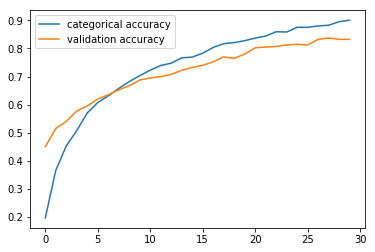

In [19]:
plt.plot(cat_acc, label = 'categorical accuracy')
plt.plot(val_acc, label = 'validation accuracy')
plt.legend()

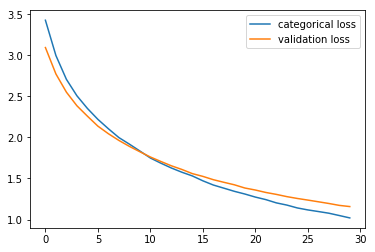

In [20]:
plt.plot(cat_loss, label = 'categorical loss')
plt.plot(val_loss, label = 'validation loss')
plt.legend()

#### Determine the best performing model

In [21]:
# Make Prediction on Test set
TEST_STEPS = len(test_files)//BATCH_SIZE
pred_probs = model.predict_generator(generator = batch_generator(test_files, BATCH_SIZE), 
                                     steps=TEST_STEPS)
pred = np.argmax(pred_probs, axis=-1)

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)
/opt/conda

### Evaluation of the best performing model

In [22]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
import itertools
from itertools import cycle
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/_encoders.py:373: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. You can use the 'categories' keyword instead. 'n_values=n' corresponds to 'categories=[range(n)] * n_features'.
  warnings.warn(msg, DeprecationWarning)


Confusion matrix, without normalization
[[27  0  0  0  0  0  0  0  0  0]
 [ 0 44  0  0  0  0  0  0  0  0]
 [ 2  0 41  2  0  1  0  1  0  1]
 [ 0  1  0 31  2  0  0  2  1  0]
 [ 0  0  0  1 42  0  0  2  4  0]
 [ 1  1  0  0  0 31  0  0  1  0]
 [ 0  0  1  0  1  0 33  0  0  0]
 [ 0  0  0  0  1  0  0 36  2  0]
 [ 0  0  0  4  2  2  0  1 37  0]
 [ 3  0  3  4  0  0  2  2  2 25]]


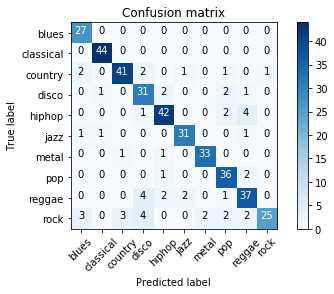

In [23]:
plot_confusion_matrix(confusion_matrix(y_true=test_labels[:len(pred)], y_pred=pred), 
                      classes=label_dict.keys())

In [24]:
print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_true=test_labels[:len(pred)], y_pred=pred)))
print('Test Set F-score =  {0:.2f}'.format(f1_score(y_true=test_labels[:len(pred)], y_pred=pred, average='macro')))

Test Set Accuracy =  0.87
Test Set F-score =  0.87


In [25]:
one_hot_true = one_hot_encoder(test_labels, len(pred), len(label_dict))
print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))

ROC AUC = 0.987


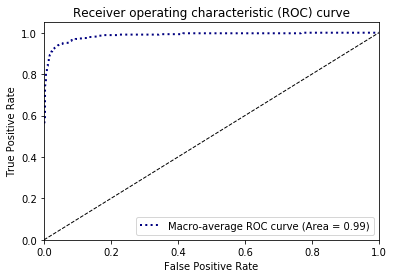

In [26]:
# Compute macro-average ROC curve and ROC area
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(one_hot_true[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])    

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(NUM_CLASSES):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= NUM_CLASSES

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (Area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()